In [1]:
# For Colab
!pip install -q yfinance
!pip install -q pmdarima

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as optimize
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = [16, 9]
plt.rcParams['axes.grid'] = True

Download Financial Securities (2010-2019)
1. Bank of America Corporation (BAC)
2. Advanced Micro Devices, Inc. (AMD)
3. American Airlines Group Inc. (AAL)
4. Invesco QQQ Trust (QQQ)
5. General Electric Company	(GE)

In [4]:
data = yf.download('AAL AMD BAC GE QQQ', start='2010-01-01', end='2019-12-31')
data.fillna(method='bfill', inplace=True)
data.columns

[*********************100%***********************]  5 of 5 completed


MultiIndex([('Adj Close', 'AAL'),
            ('Adj Close', 'AMD'),
            ('Adj Close', 'BAC'),
            ('Adj Close',  'GE'),
            ('Adj Close', 'QQQ'),
            (    'Close', 'AAL'),
            (    'Close', 'AMD'),
            (    'Close', 'BAC'),
            (    'Close',  'GE'),
            (    'Close', 'QQQ'),
            (     'High', 'AAL'),
            (     'High', 'AMD'),
            (     'High', 'BAC'),
            (     'High',  'GE'),
            (     'High', 'QQQ'),
            (      'Low', 'AAL'),
            (      'Low', 'AMD'),
            (      'Low', 'BAC'),
            (      'Low',  'GE'),
            (      'Low', 'QQQ'),
            (     'Open', 'AAL'),
            (     'Open', 'AMD'),
            (     'Open', 'BAC'),
            (     'Open',  'GE'),
            (     'Open', 'QQQ'),
            (   'Volume', 'AAL'),
            (   'Volume', 'AMD'),
            (   'Volume', 'BAC'),
            (   'Volume',  'GE'),
            ( 

In [5]:
data.head()

Adj Close                   ...     Volume                     
                 AAL   AMD        BAC  ...        BAC         GE       QQQ
Date                                   ...                                
2010-01-04  4.496876  9.70  13.731325  ...  180845200   69763000  62822800
2010-01-05  5.005957  9.71  14.177655  ...  209521300   67132600  62935600
2010-01-06  4.798555  9.57  14.343938  ...  205257900   57683400  96033000
2010-01-07  4.939965  9.47  14.816527  ...  320868400  192891100  77094100
2010-01-08  4.845690  9.43  14.685253  ...  220104700  119717100  88886600

[5 rows x 30 columns]

In [6]:
data.tail()

Adj Close                        ...    Volume                    
                  AAL        AMD        BAC  ...       BAC        GE       QQQ
Date                                         ...                              
2019-12-23  29.192120  45.459999  34.251415  ...  33995400  44033200  23774700
2019-12-24  29.072563  46.540001  34.300117  ...  13805400  20769000   7089000
2019-12-26  29.560759  46.630001  34.592278  ...  26992100  30366700  17067500
2019-12-27  28.335287  46.180000  34.426716  ...  28111300  29971800  18134100
2019-12-30  28.195801  45.520000  34.231945  ...  30705100  48146000  21815500

[5 rows x 30 columns]

Rolling Value at Risk

In [7]:
# Monte Carlo parameters
investment_value = 10000
confidence_level = 0.01 # 99% confident interval
assets = ['AAL', 'AMD', 'BAC', 'GE', 'QQQ']
T = 10
weights = [.2, .2, .1, .1, .4]
n_simulates = 10 ** 5
n_assets = len(assets)

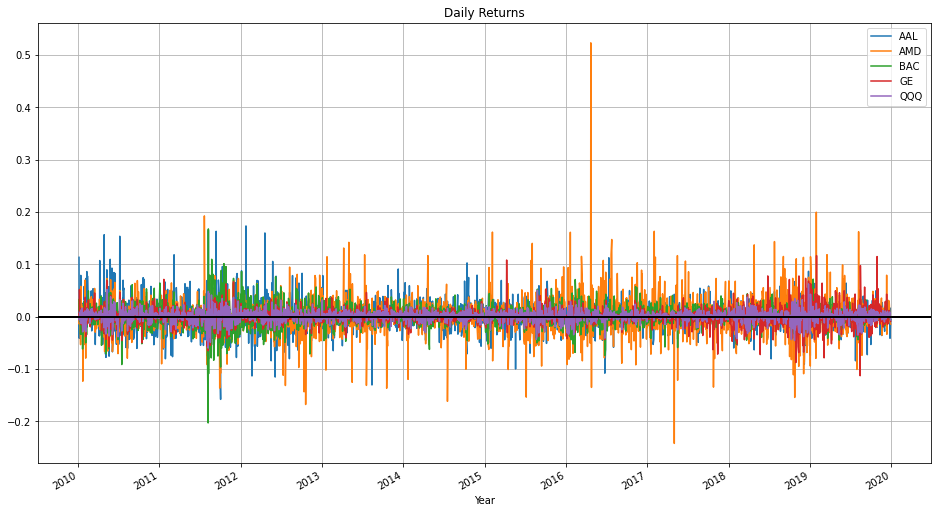

In [8]:
daily_returns = data['Adj Close'].apply(lambda x: x / x[0]).pct_change().dropna()
daily_returns.plot(grid=True, title='Daily Returns', xlabel='Year').axhline(color='black', lw=2)

In [9]:
# covariance matrix
cov_mat = daily_returns.cov()

# Cholesky decomposition of the covariance matrix
chol_mat = np.linalg.cholesky(cov_mat)

# correlated random numbers from the Standard Normal distribution
rv = np.random.normal(size=(n_simulates, len(daily_returns.columns)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

r = np.mean(daily_returns, axis=0).values
sigma = np.std(daily_returns, axis=0).values
S_0 = data['Adj Close'].values[-1, :]
P_0 = np.sum(weights * S_0)

# terminal price
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)

# terminal portfolio value
P_T = np.sum(weights * S_T, axis=1)

# portfolio returns
P_diff = P_T - P_0

# VaR
P_diff_sorted = np.sort(P_diff)
percentiles = 1. # 99% confidence interval
var = np.percentile(P_diff_sorted, percentiles)
print(f'1-day VaR with 99% confidence interval: {-var} $')

1-day VaR with 99% confidence interval: -0.4942103226935812 $


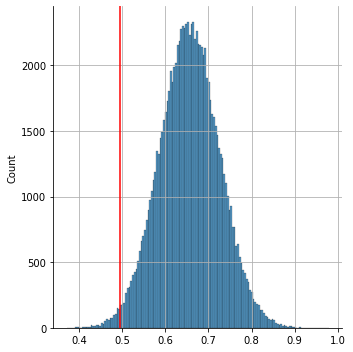

In [10]:
ax = sns.displot(data=P_diff, kde=False)
ax.set_titles('Distribution of possible 1-day changes in portfolio value 1-day 99% VaR')
plt.axvline(var, 0, 10000, color='r')

Expected Shortfall

In [11]:
var = np.percentile(P_diff_sorted, 1)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()
print(f'The 1-day 99% VaR is {-var} $, and the accompanying Expected Shortfall is {-expected_shortfall} $.')

The 1-day 99% VaR is -0.4942103226935812 $, and the accompanying Expected Shortfall is -0.47088557799092895 $.


Portfolio Optimization

In [12]:
daily_average_returns = np.log(data['Adj Close']/data['Adj Close'].shift(1))

In [13]:
def portfolio_simulation(iterations):
    start = time.time()
    
    port_returns = []
    port_vols = []
    
    for i in range (iterations):
        weights = np.random.dirichlet(np.ones(n_assets),size=1)
        weights = weights[0]
        port_returns.append(np.sum(daily_average_returns.mean() * weights) * 252)
        port_vols.append(np.sqrt(np.dot(weights.T, np.dot(daily_average_returns.cov() * 252, weights))))
    
    port_returns = np.array(port_returns)
    port_vols = np.array(port_vols)
 
    plt.figure(figsize = (18,10))
    plt.scatter(port_vols, port_returns, c=(port_returns/port_vols), marker='o')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label = 'Sharpe ratio (not adjusted for short rate)')
    
    print('Elapsed Time: %.2f seconds' % (time.time() - start))
    
    return port_returns, port_vols

Elapsed Time: 3.43 seconds


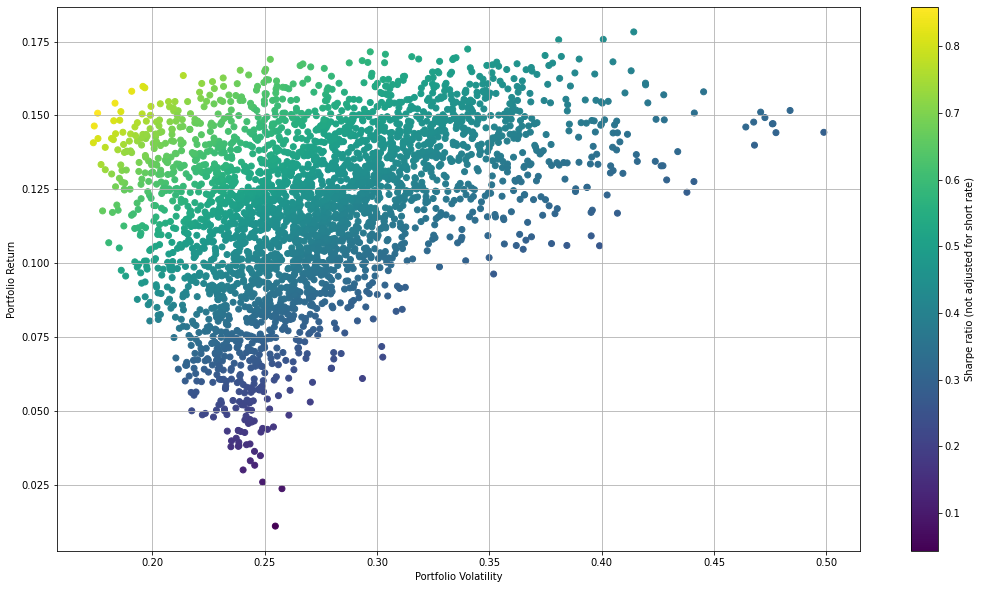

In [14]:
port_returns, port_vols = portfolio_simulation(3000)

In [15]:
def portfolio_stats(weights):
    weights = np.array(weights)
    port_return = np.sum(daily_average_returns.mean() * weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(daily_average_returns.cov() * 252, weights)))
    sharpe = port_return/port_vol

    return {'return': port_return, 'volatility': port_vol, 'sharpe': sharpe}

In [16]:
def minimize_sharpe(weights):  
    return -portfolio_stats(weights)['sharpe'] 

In [17]:
def minimize_volatility(weights):  
    return portfolio_stats(weights)['volatility'] 

In [18]:
def minimize_return(weights): 
    return -portfolio_stats(weights)['return']

In [19]:
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(n_assets))
initializer = n_assets * [1./n_assets,]

print(initializer)
print(bounds)

[0.2, 0.2, 0.2, 0.2, 0.2]
((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))


In [20]:
optimal_sharpe = optimize.minimize(minimize_sharpe,
                                   initializer,
                                   method = 'SLSQP',
                                   bounds = bounds,
                                   constraints = constraints)
print(optimal_sharpe)

     fun: -0.9423152003563018
     jac: array([ 3.23097333e-02,  5.44384204e-01,  5.22733562e-01,  7.26831920e-01,
       -7.45058060e-09])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([3.58046925e-15, 7.14706072e-16, 1.94982919e-15, 1.11716192e-15,
       1.00000000e+00])


In [21]:
optimal_sharpe_weights = optimal_sharpe['x'].round(4)
list(zip(assets, list(optimal_sharpe_weights)))

[('AAL', 0.0), ('AMD', 0.0), ('BAC', 0.0), ('GE', 0.0), ('QQQ', 1.0)]

In [22]:
optimal_stats = portfolio_stats(optimal_sharpe_weights)
print(optimal_stats)
print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

{'return': 0.16283757270342145, 'volatility': 0.1728058431423477, 'sharpe': 0.9423152003563041}
Optimal Portfolio Return:  16.2838
Optimal Portfolio Volatility:  17.2806
Optimal Portfolio Sharpe Ratio:  0.9423


Efficient Frontier

In [23]:
optimal_variance = optimize.minimize(minimize_volatility,
                                     initializer,
                                     method = 'SLSQP',
                                     bounds = bounds,
                                     constraints = constraints)
print(optimal_variance)

     fun: 0.17047791314458816
     jac: array([0.20378944, 0.26447711, 0.20109322, 0.17048189, 0.17047736])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([5.04264750e-18, 8.35715109e-18, 1.53281698e-17, 1.22908412e-01,
       8.77091588e-01])


In [24]:
optimal_variance_weights = optimal_variance['x'].round(4)
list(zip(assets,list(optimal_variance_weights)))

[('AAL', 0.0), ('AMD', 0.0), ('BAC', 0.0), ('GE', 0.1229), ('QQQ', 0.8771)]

In [25]:
target_returns = np.linspace(port_returns.min(), port_returns.max(), 50)

minimal_volatilities = []
bounds = tuple((0,1) for x in weights)
initializer = n_assets * [1./n_assets,]

for target_return in target_returns:
    
    constraints = ({'type':'eq','fun': lambda x: portfolio_stats(x)['return']-target_return},
                   {'type':'eq','fun': lambda x: np.sum(x)-1})
       
    optimal = optimize.minimize(minimize_volatility,
                              initializer,
                              method = 'SLSQP',
                              bounds = bounds,
                              constraints = constraints)
    
    minimal_volatilities.append(optimal['fun'])

minimal_volatilities = np.array(minimal_volatilities)

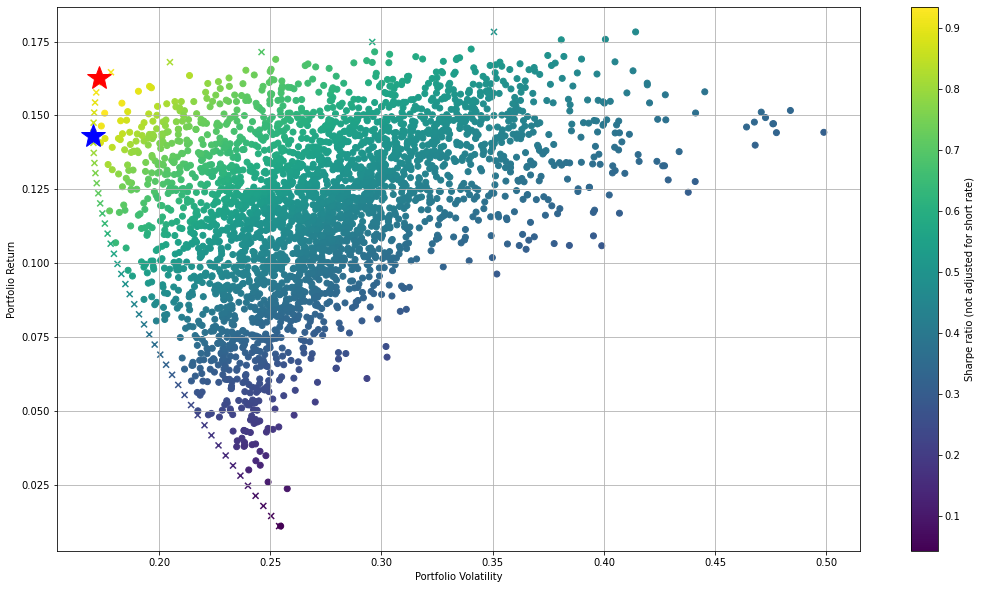

In [26]:
plt.figure(figsize=(18,10))

plt.scatter(port_vols,
            port_returns,
            c = (port_returns / port_vols),
            marker = 'o')

plt.scatter(minimal_volatilities,
            target_returns,
            c = (target_returns / minimal_volatilities),
            marker = 'x')

plt.plot(portfolio_stats(optimal_sharpe_weights)['volatility'],
         portfolio_stats(optimal_sharpe_weights)['return'],
         'r*',
         markersize = 25.0)

plt.plot(portfolio_stats(optimal_variance_weights)['volatility'],
         portfolio_stats(optimal_variance_weights)['return'],
         'b*',
         markersize = 25.0)

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe ratio (not adjusted for short rate)')

- Portfolio with optimal sharpe weights is better than portfolio with optimal variance weights because it offer higher expected return.

Seasonality, Trends, and Stationarity

In [27]:
daily_log_returns = daily_returns.cumsum().dropna()

In [28]:
def SeasonalDecompose(returns):
    decompose_result = seasonal_decompose(returns, period=12)
    fig = decompose_result.plot()
    return decompose_result

In [29]:
def SeasonalStationarity(returns, decompose_result):
    df_trend = decompose_result.trend
    df_season = decompose_result.seasonal
    df_residual = decompose_result.resid

    df_log_diff = df_residual.diff().dropna()
    df_diff_rolling = df_log_diff.rolling(12)
    df_diff_mean = df_diff_rolling.mean()
    df_diff_std = df_diff_rolling.std()

    plt.figure(figsize=(16, 9))
    plt.plot(df_log_diff, label='Differenced')
    plt.plot(df_diff_mean, label='Mean')
    plt.plot(df_diff_std, label='Std')
    plt.legend()

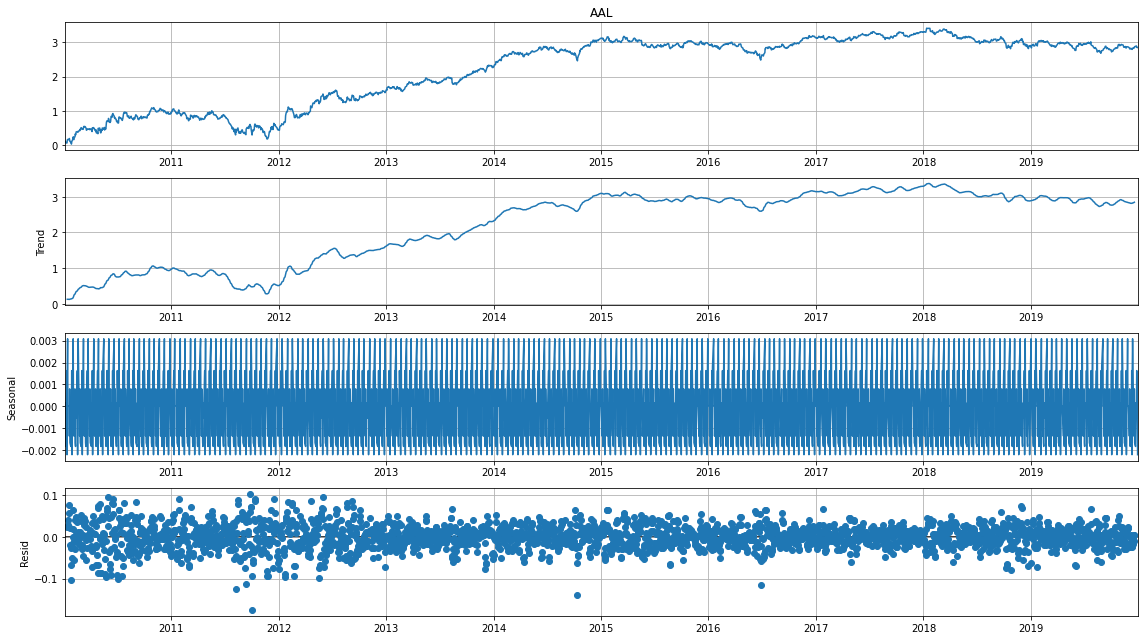

In [30]:
decompose_result = SeasonalDecompose(daily_log_returns['AAL'])

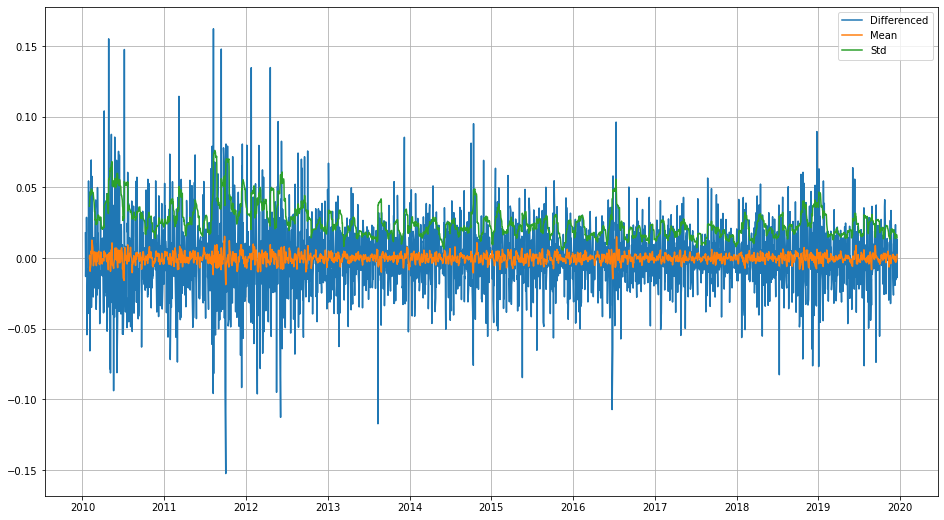

In [31]:
SeasonalStationarity(daily_log_returns['AAL'], decompose_result)

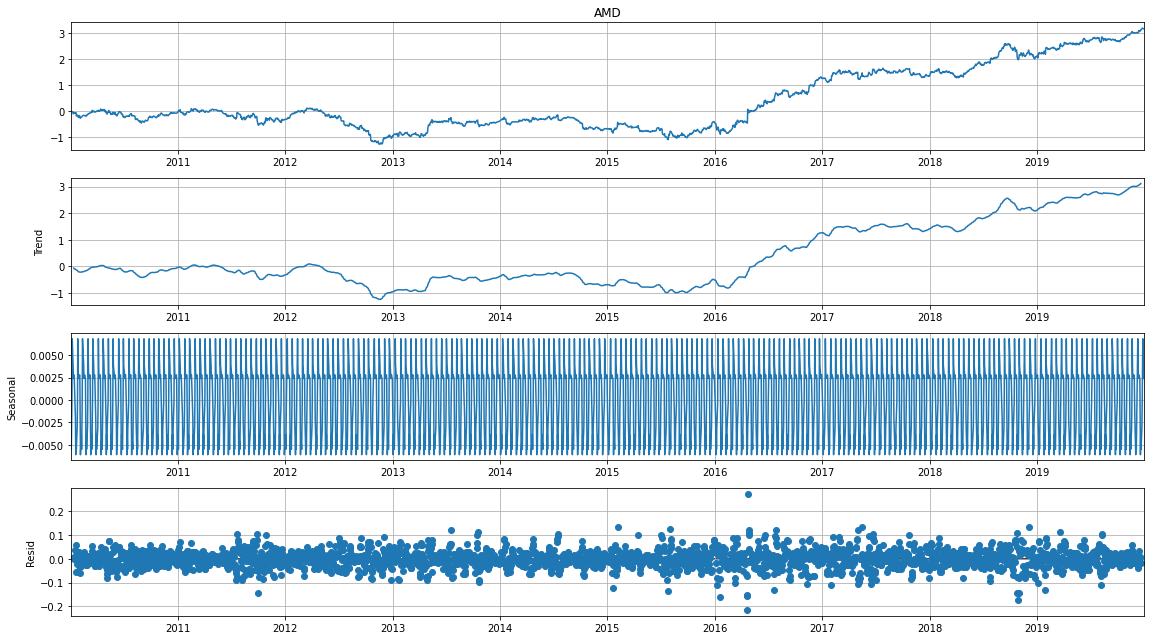

In [32]:
decompose_result = SeasonalDecompose(daily_log_returns['AMD'])

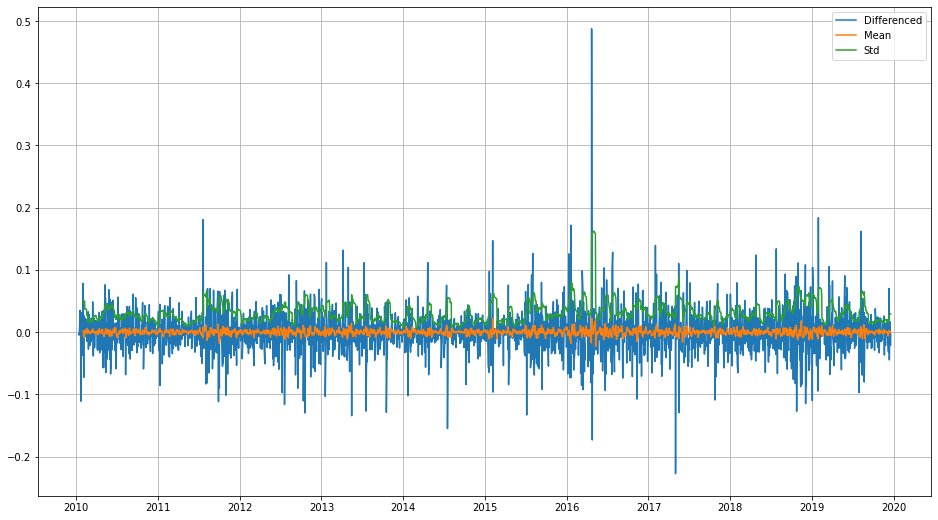

In [33]:
SeasonalStationarity(daily_log_returns['AMD'], decompose_result)

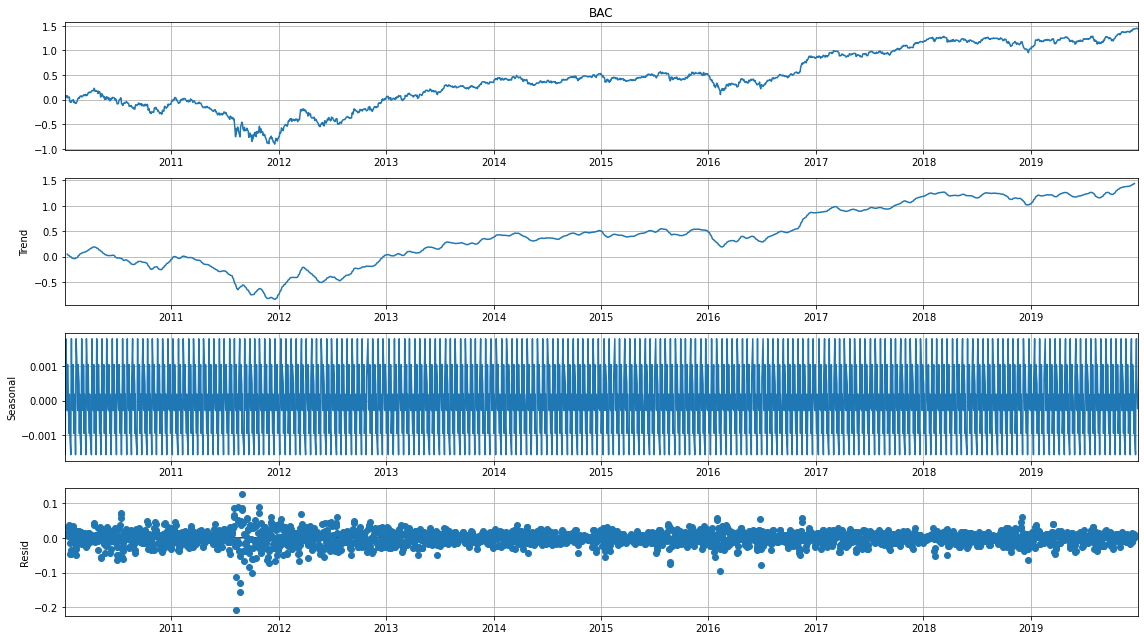

In [34]:
decompose_result = SeasonalDecompose(daily_log_returns['BAC'])

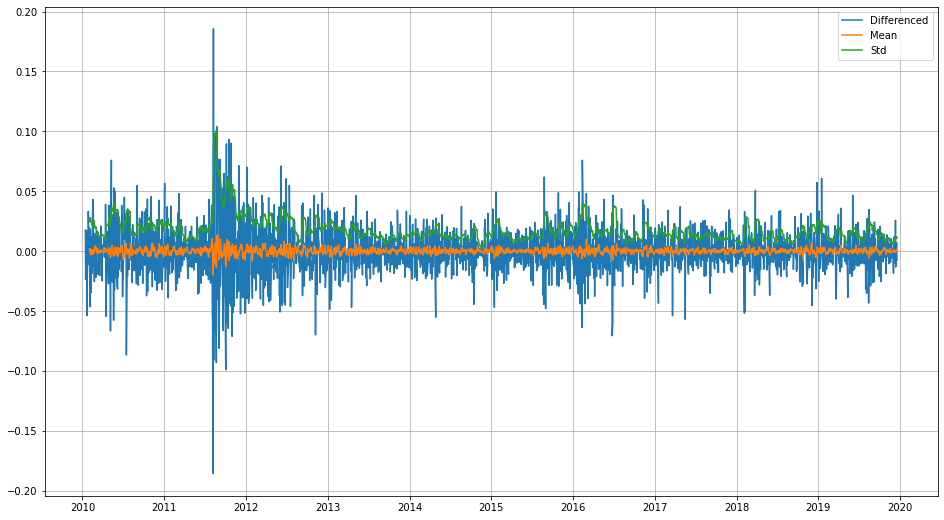

In [35]:
SeasonalStationarity(daily_log_returns['BAC'], decompose_result)

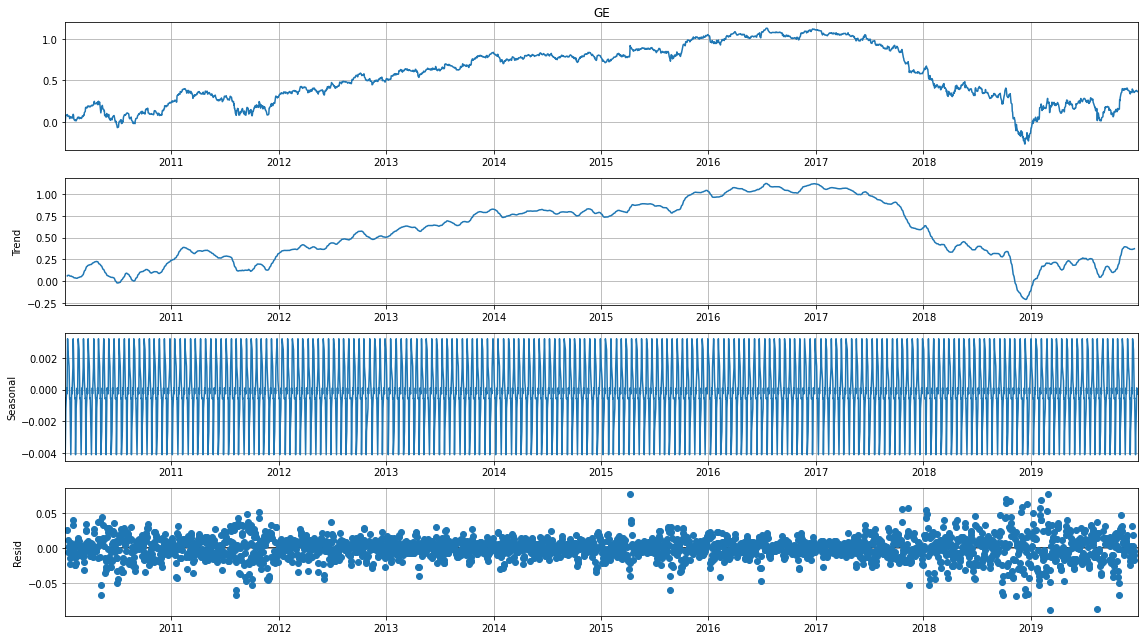

In [36]:
decompose_result = SeasonalDecompose(daily_log_returns['GE'])

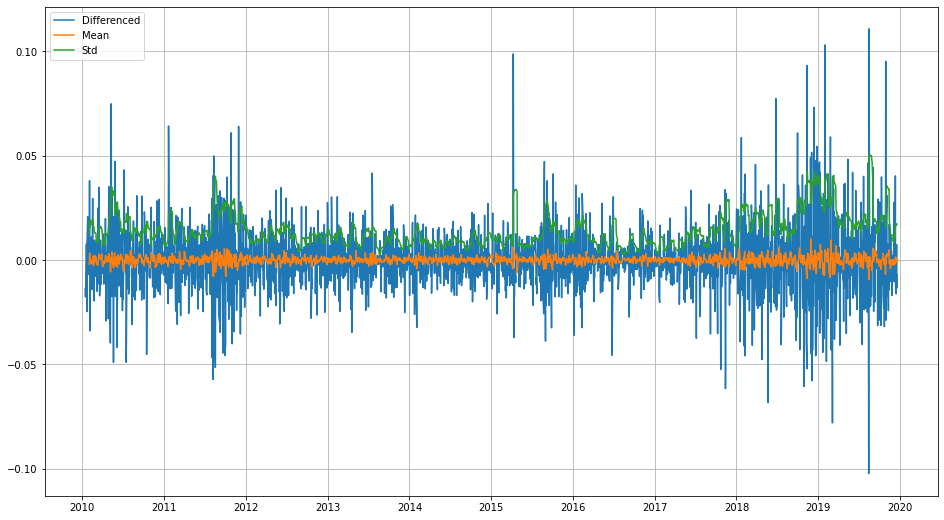

In [37]:
SeasonalStationarity(daily_log_returns['GE'], decompose_result)

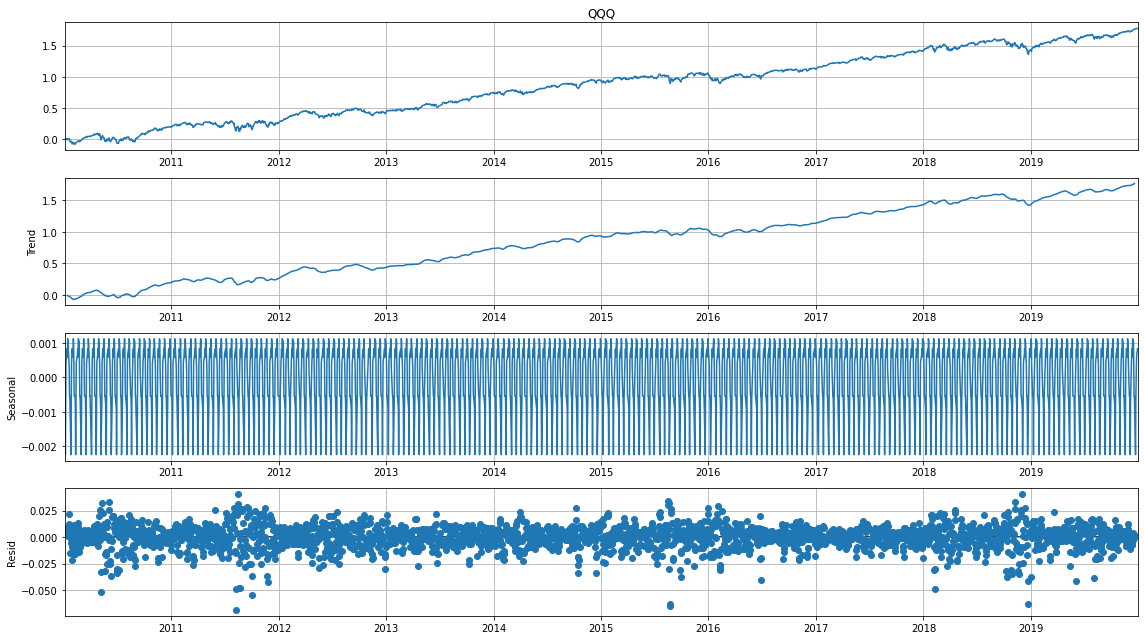

In [38]:
decompose_result = SeasonalDecompose(daily_log_returns['QQQ'])

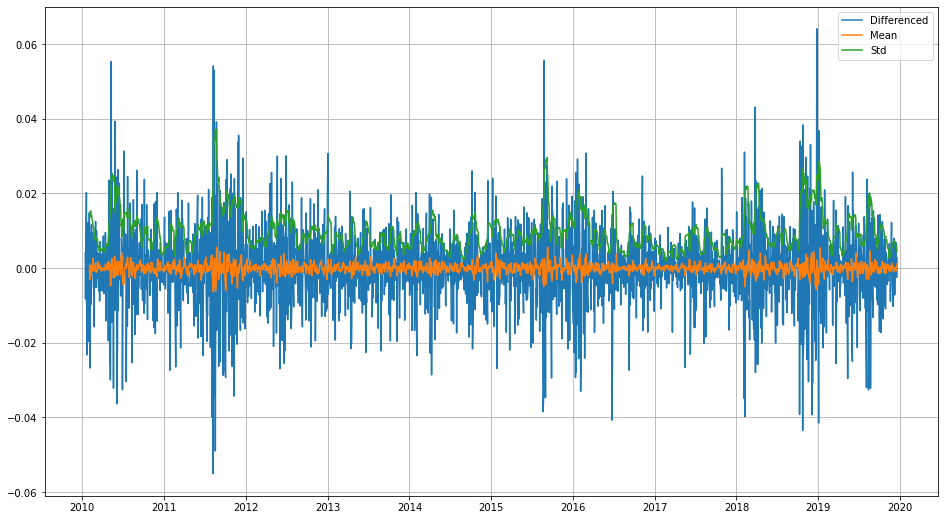

In [39]:
SeasonalStationarity(daily_log_returns['QQQ'], decompose_result)

ARIMA Models

In [40]:
n_periods = 30
training_set = daily_log_returns.loc['2019-1-1':'2019-12-31'].dropna()

In [41]:
def AutoModelARIMA(returns):
    model = pm.auto_arima(returns.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    print(model.summary())
    return model

In [42]:
def PlotModelARIMA(model):
    model.plot_diagnostics()
    plt.show()

In [43]:
def PredictModelARIMA(returns, model):
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = np.arange(len(returns.values), len(returns.values)+n_periods)

    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    plt.plot(returns.values)
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)
    plt.show()

In [44]:
model = AutoModelARIMA(training_set['AAL'])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1179.332, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1247.693, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1177.010, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1179.080, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1177.076, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1191.386, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-794.262, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1191.399, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-534.268, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1191.415, Time=0.36 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-118

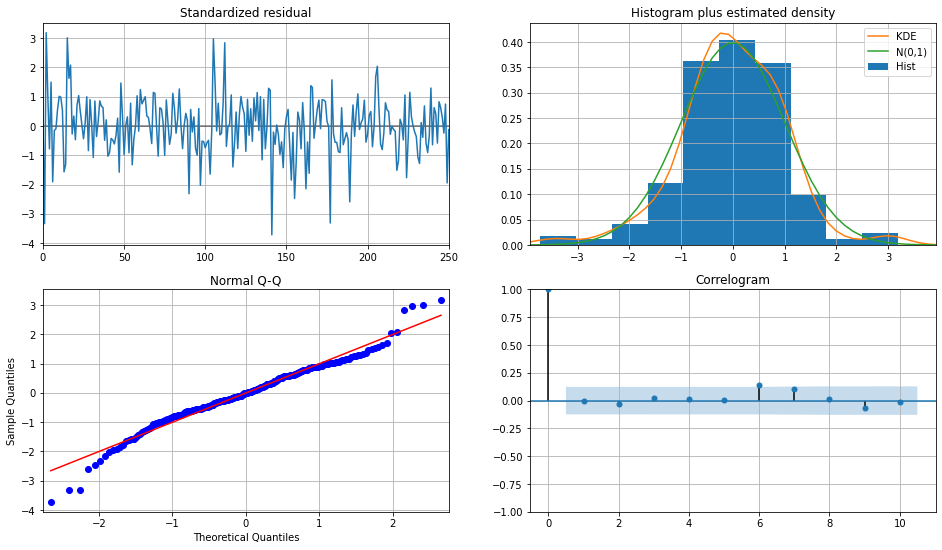

In [45]:
PlotModelARIMA(model)

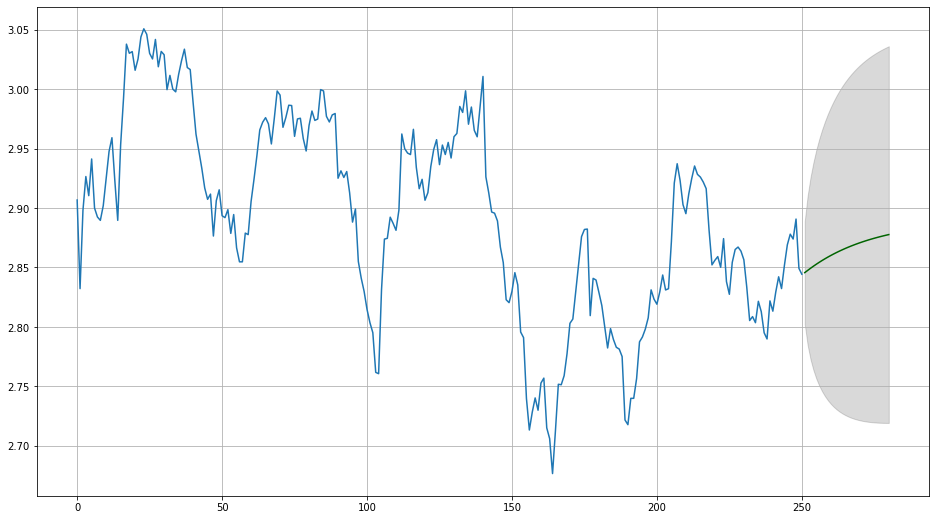

In [46]:
PredictModelARIMA(training_set['AAL'], model)

In [47]:
model = AutoModelARIMA(training_set['AMD'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-977.664, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-975.842, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-975.893, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-976.054, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.166 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 490.832
Date:                Wed, 30 Dec 2020   AIC                           -977.664
Time:                        11:44:45   BIC                           -970.621
Sample:                             0   HQIC                          -974.830
                                - 251                                         
Co

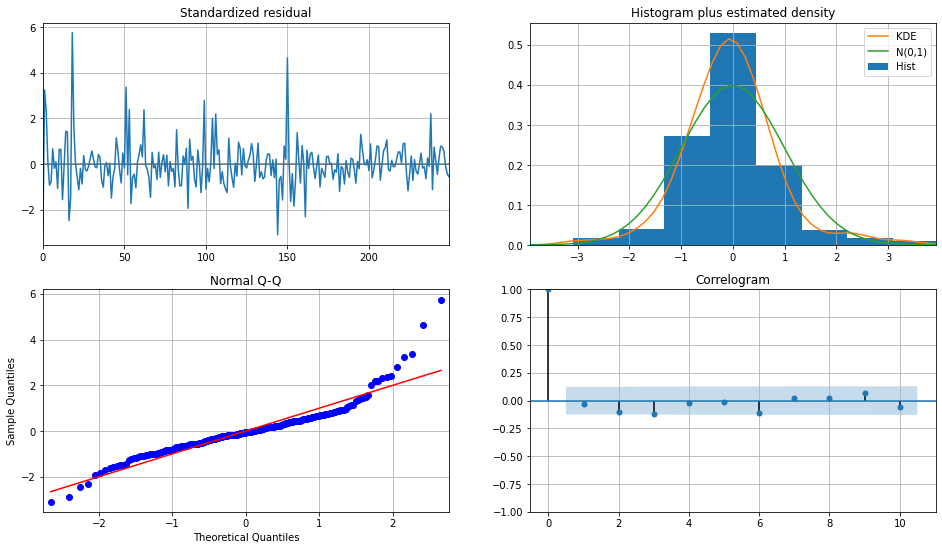

In [48]:
PlotModelARIMA(model)

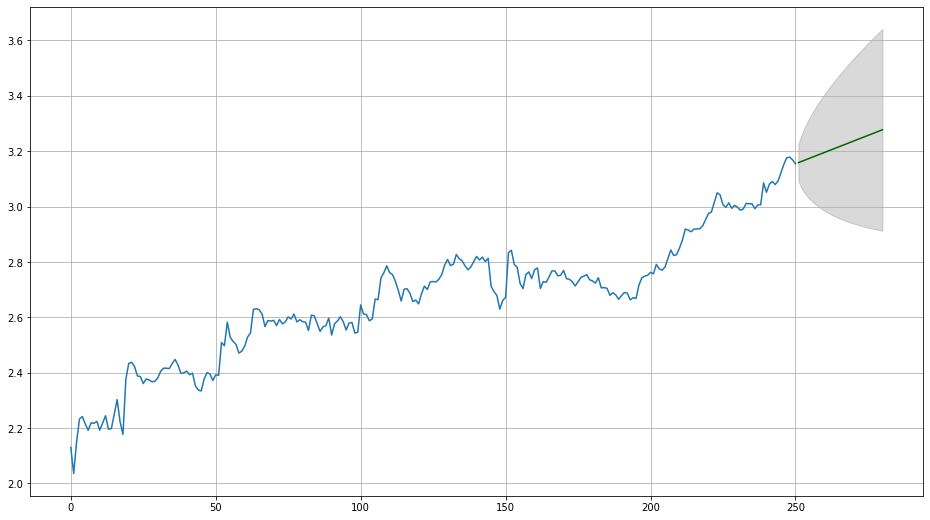

In [49]:
PredictModelARIMA(training_set['AMD'], model)

In [50]:
model = AutoModelARIMA(training_set['BAC'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1397.344, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1399.828, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1398.570, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1398.492, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1398.966, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.394 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 701.914
Date:                Wed, 30 Dec 2020   AIC                          -1399.828
Time:                        11:44:46   BIC                          -1392.785
Sample:                             0   HQIC                         -1396.993
                                - 251                                  

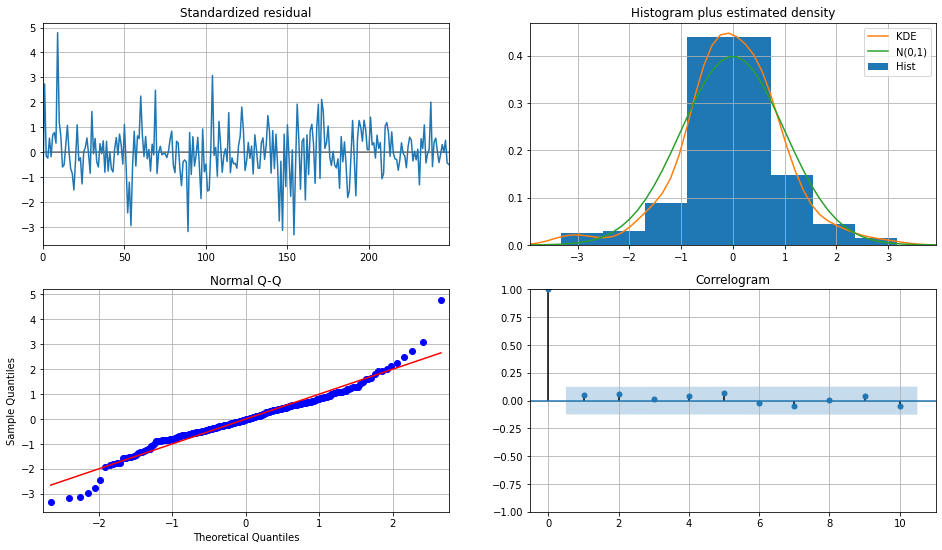

In [51]:
PlotModelARIMA(model)

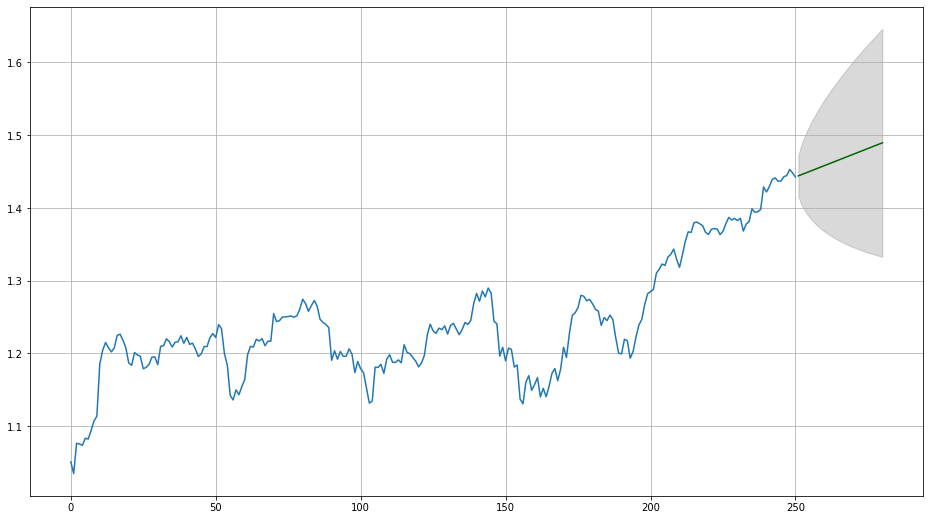

In [52]:
PredictModelARIMA(training_set['BAC'], model)

In [53]:
model = AutoModelARIMA(training_set['GE'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1118.812, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1122.717, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1121.170, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1121.201, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1123.505, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.508 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 562.753
Date:                Wed, 30 Dec 2020   AIC                          -1123.505
Time:                        11:44:47   BIC                          -1119.984
Sample:                             0   HQIC                         -1122.088
                                - 251                                  

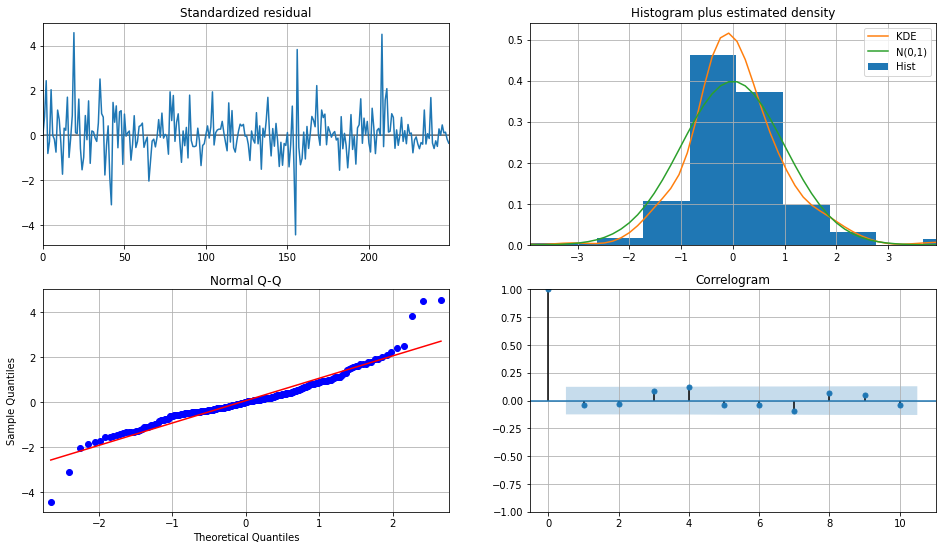

In [54]:
PlotModelARIMA(model)

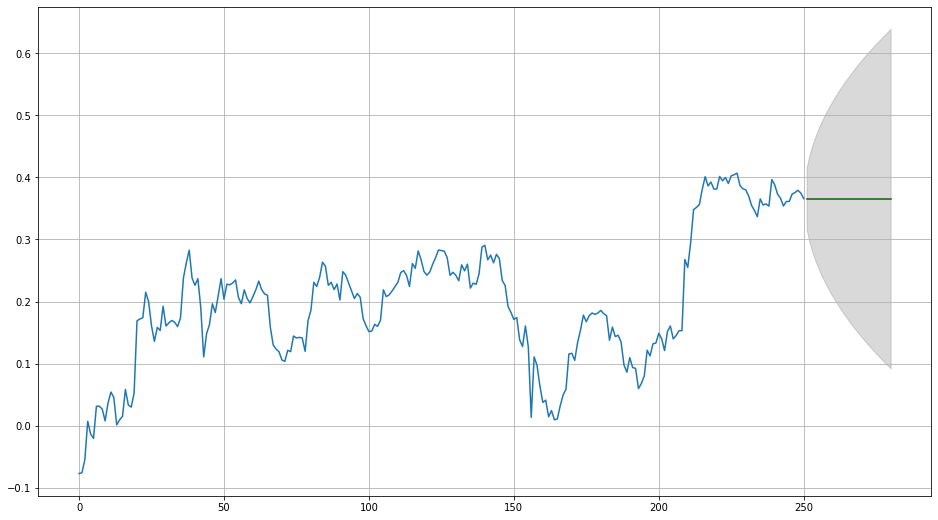

In [55]:
PredictModelARIMA(training_set['GE'], model)

In [56]:
model = AutoModelARIMA(training_set['QQQ'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1578.375, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1578.320, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1577.858, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1578.382, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1576.021, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1580.202, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1578.512, Time=0.69 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1578.128, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1576.720, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1575.604, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.223 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(0, 1, 2)   Log Likeliho

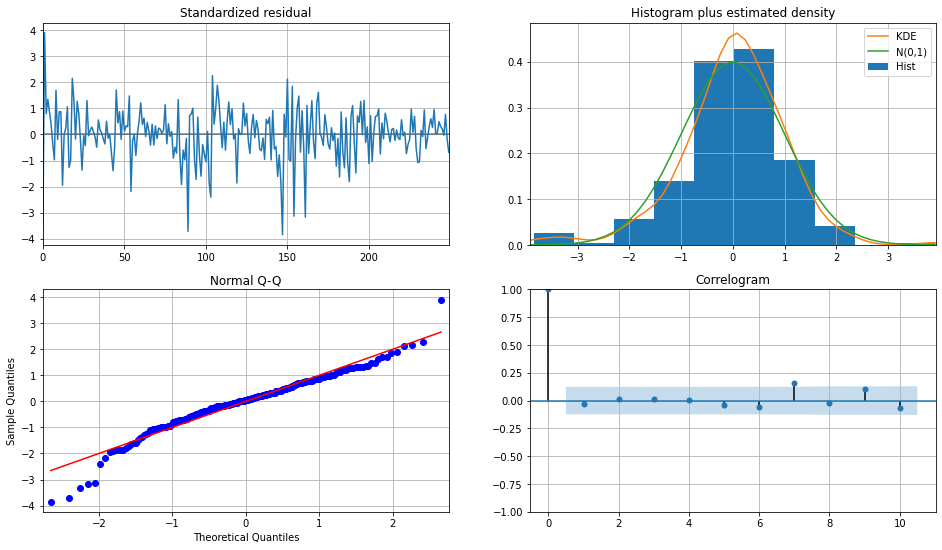

In [57]:
PlotModelARIMA(model)

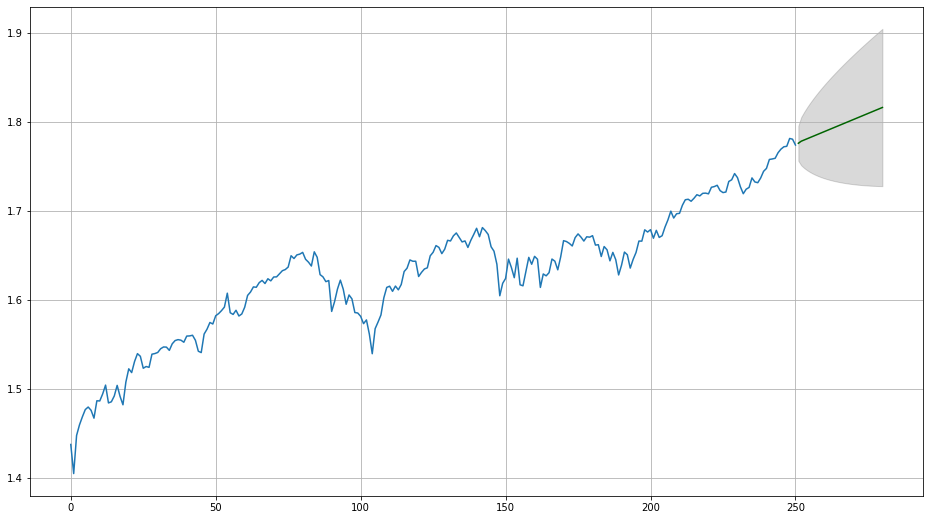

In [58]:
PredictModelARIMA(training_set['QQQ'], model)